## Import the Basic Packages

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime as dt
%matplotlib inline
import math
import pandas_profiling
from sklearn.model_selection import train_test_split
from sklearn import metrics

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression

print(pd.__version__)
print(np.__version__)
print(sns.__version__)

0.25.3
1.16.5
0.9.0


## Create the UDF's

In [4]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([
        x.count(),
        x.isnull().sum(),
        x.sum(),
        x.mean(),
        x.median(),
        x.std(),
        x.var(),
        x.min(),
        x.quantile(0.01),
        x.quantile(0.05),
        x.quantile(0.10),
        x.quantile(0.25),
        x.quantile(0.50),
        x.quantile(0.75),
        x.quantile(0.90),
        x.quantile(0.95),
        x.quantile(0.99),
        x.max()
    ],
                     index=[
                         'N', 'NMISS', 'SUM', 'MEAN', 'MEDIAN', 'STD', 'VAR',
                         'MIN', 'P1', 'P5', 'P10', 'P25', 'P50', 'P75', 'P90',
                         'P95', 'P99', 'MAX'
                     ])

In [5]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending=False)[0:1].reset_index()
    return pd.Series([
        x.count(),
        x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1],
        round(Mode.iloc[0, 1] * 100 / x.count(), 2)
    ],
                     index=['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [6]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats='mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode())
    return x

In [7]:
#An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop(colname, axis=1, inplace=True)
    return df

In [8]:
# create user defined function to create the freq plots
def fn_countplot(pd_series):
    plt.figure(figsize=(5, 3))
    sns.countplot(y=pd_series)
    print('This is a freq chart for ' + pd_series.name)
    plt.show()
    return

In [9]:
# attach the column names to the dataset

col_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root",
    "num_file_creations", "num_shells", "num_access_files",
    "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
    "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "attack", "last_flag"
]

df_train = pd.read_table(
    'C:/Data Sets/(Class 21-Python - Case Study)/3. Network Intrusion Detection System/NSL_Dataset/train.txt',
    names=col_names,  #Adding the column names
    index_col=False,      #Removing the first column values from becoming an index.
    sep=','                      #Separator used to separate the values and create a readable DataFrame
)  
df_test = pd.read_table(
    'C:/Data Sets/(Class 21-Python - Case Study)/3. Network Intrusion Detection System/NSL_Dataset/test.txt',
    names=col_names,   #Adding the column names for the test dataset
    index_col=False,       #Removing the first column values from becoming an index for the test dataset
    sep=',')                      #Separator used to separate the values and create a readable DataFrame for the test dataset

# shape, this gives the dimensions of the dataset
print('Dimensions of the Training set:', df_train.shape)
print('Dimensions of the Test set:', df_test.shape)

Dimensions of the Training set: (125973, 43)
Dimensions of the Test set: (22544, 43)


In [10]:
df_train.head()  #First 5 values for basic assesment.

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [11]:
df_test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11


In [12]:
df_train.info() #Basic Information check for null values and data types.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
duration                       125973 non-null int64
protocol_type                  125973 non-null object
service                        125973 non-null object
flag                           125973 non-null object
src_bytes                      125973 non-null int64
dst_bytes                      125973 non-null int64
land                           125973 non-null int64
wrong_fragment                 125973 non-null int64
urgent                         125973 non-null int64
hot                            125973 non-null int64
num_failed_logins              125973 non-null int64
logged_in                      125973 non-null int64
num_compromised                125973 non-null int64
root_shell                     125973 non-null int64
su_attempted                   125973 non-null int64
num_root                       125973 non-null int64
num_file_creations             125973 

In [13]:
#Initially we are working on binomial classification so classifying data accordingly.
#In attack variable normal means 0 and 1 means attacked.

df_train.loc[df_train.attack == 'normal', 'attack'] = 0

df_train.loc[(df_train.attack == 'back') | (df_train.attack == 'land') |
             (df_train.attack == 'pod') | (df_train.attack == 'neptune') |
             (df_train.attack == 'smurf') | (df_train.attack == 'teardrop') |
             (df_train.attack == 'apache2') | (df_train.attack == 'udpstorm') |
             (df_train.attack == 'processtable') | (df_train.attack == 'worm')
             | (df_train.attack == 'mailbomb') | (df_train.attack == 'satan') |
             (df_train.attack == 'ipsweep') | (df_train.attack == 'nmap') |
             (df_train.attack == 'portsweep') | (df_train.attack == 'mscan') |
             (df_train.attack == 'saint') | (df_train.attack == 'guess_passwd')
             | (df_train.attack == 'ftp_write') | (df_train.attack == 'imap') |
             (df_train.attack == 'phf') | (df_train.attack == 'multihop') |
             (df_train.attack == 'warezmaster') |
             (df_train.attack == 'warezclient') | (df_train.attack == 'spy') |
             (df_train.attack == 'xlock') | (df_train.attack == 'xsnoop') |
             (df_train.attack == 'snmpguess') |
             (df_train.attack == 'snmpgetattack') |
             (df_train.attack == 'httptunnel') |
             (df_train.attack == 'sendmail') | (df_train.attack == 'named') |
             (df_train.attack == 'buffer_overflow') |
             (df_train.attack == 'loadmodule') | (df_train.attack == 'rootkit')
             | (df_train.attack == 'perl') | (df_train.attack == 'sqlattack') |
             (df_train.attack == 'xterm') | (df_train.attack == 'ps'),
             'attack'] = 1

In [14]:
#We will do the same for the test data

df_test.loc[df_test.attack == 'normal', 'attack'] = 0

df_test.loc[(df_test.attack == 'back') | (df_test.attack == 'land') |
            (df_test.attack == 'pod') | (df_test.attack == 'neptune') |
            (df_test.attack == 'smurf') | (df_test.attack == 'teardrop') |
            (df_test.attack == 'apache2') | (df_test.attack == 'udpstorm') |
            (df_test.attack == 'processtable') | (df_test.attack == 'worm')
            | (df_test.attack == 'mailbomb') | (df_test.attack == 'satan') |
            (df_test.attack == 'ipsweep') | (df_test.attack == 'nmap') |
            (df_test.attack == 'portsweep') | (df_test.attack == 'mscan') |
            (df_test.attack == 'saint') | (df_test.attack == 'guess_passwd')
            | (df_test.attack == 'ftp_write') | (df_test.attack == 'imap') |
            (df_test.attack == 'phf') | (df_test.attack == 'multihop') |
            (df_test.attack == 'warezmaster') |
            (df_test.attack == 'warezclient') | (df_test.attack == 'spy') |
            (df_test.attack == 'xlock') | (df_test.attack == 'xsnoop') |
            (df_test.attack == 'snmpguess') |
            (df_test.attack == 'snmpgetattack') |
            (df_test.attack == 'httptunnel') | (df_test.attack == 'sendmail') |
            (df_test.attack == 'named') | (df_test.attack == 'buffer_overflow')
            | (df_test.attack == 'loadmodule') | (df_test.attack == 'rootkit')
            | (df_test.attack == 'perl') | (df_test.attack == 'sqlattack') |
            (df_test.attack == 'xterm') | (df_test.attack == 'ps'),
            'attack'] = 1

df_test

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,1,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,1,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,0,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,1,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,SF,794,333,0,0,0,0,...,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,0,21
22540,0,tcp,http,SF,317,938,0,0,0,0,...,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,0,21
22541,0,tcp,http,SF,54540,8314,0,0,0,2,...,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,1,15
22542,0,udp,domain_u,SF,42,42,0,0,0,0,...,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,0,21


In [8]:
#Pandas Profiling for the data
#report = pandas_profiling.ProfileReport(df_train)
#report.to_file(
#    output_file=
#    'C:/Data Sets/(Class 21-Python - Case Study)/3. Network Intrusion Detection System/profilereportbinomial.html'
#)
#report

In [23]:
#Separating the categorial and continous variables

df_train_cont = df_train.select_dtypes(['int64','float64']) 
df_train_cat = df_train.select_dtypes(['object'])

df_test_cont = df_test.select_dtypes(['int64','float64']) 
df_test_cat = df_test.select_dtypes(['object'])

In [24]:
df_train_cat.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


In [25]:
df_train_cont.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,491,0,0,0,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0,20
1,0,146,0,0,0,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0,15
2,0,0,0,0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1,19
3,0,232,8153,0,0,0,0,0,1,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0,21
4,0,199,420,0,0,0,0,0,1,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0,21


In [26]:
#Data report for checking null values and outlier data and summary.

df_train_cont.apply(continuous_var_summary).round(2)

#We found that we have outlier data. We will treat it below.
#There are no null values.

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
N,125973.00,1.259730e+05,1.259730e+05,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,...,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00,125973.00
NMISS,0.00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SUM,36172473.00,5.740179e+09,2.491634e+09,25.00,2858.00,14.00,25750.00,154.00,49852.00,35178.00,...,65662.38,10449.60,18691.73,4099.47,35833.33,35081.53,14969.60,15146.98,58630.00,2456985.00
MEAN,287.14,4.556674e+04,1.977911e+04,0.00,0.02,0.00,0.20,0.00,0.40,0.28,...,0.52,0.08,0.15,0.03,0.28,0.28,0.12,0.12,0.47,19.50
MEDIAN,0.00,4.400000e+01,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.51,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20.00
STD,2604.52,5.870331e+06,4.021269e+06,0.01,0.25,0.01,2.15,0.05,0.49,23.94,...,0.45,0.19,0.31,0.11,0.44,0.45,0.31,0.32,0.50,2.29
VAR,6783500.00,3.446079e+13,1.617061e+13,0.00,0.06,0.00,4.62,0.00,0.24,573.22,...,0.20,0.04,0.10,0.01,0.20,0.20,0.09,0.10,0.25,5.25
MIN,0.00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
P1,0.00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00
P5,0.00,0.000000e+00,0.000000e+00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.00


In [27]:
df_train_cat.apply(categorical_var_summary)

,protocol_type,service,flag
N,125973,125973,125973
NMISS,0,0,0
MODE,tcp,http,SF
FREQ,102689,40338,74945
PERCENT,81.52,32.02,59.49


In [28]:
#We found that we had outlier data in the summary so handling outliers.


def outlier_capping(x):
    x = x.clip(upper=x.quantile(0.99))
    x = x.clip(lower=x.quantile(0.01))
    return x


df_train_cont = df_train_cont.apply(outlier_capping)
df_test_cont = df_test_cont.apply(outlier_capping)

## Basic exploratory data analsysis

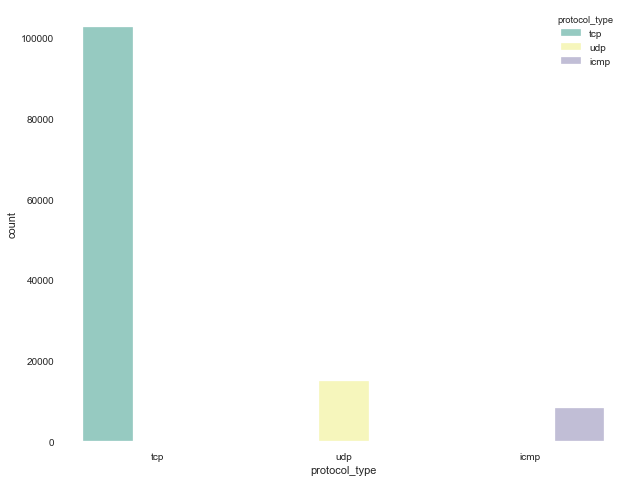

In [29]:
# Protocol type distribution
plt.figure(figsize=(10, 8))
sns.countplot(x="protocol_type",
              data=df_train,
              hue='protocol_type',
              palette="Set3")
plt.show()

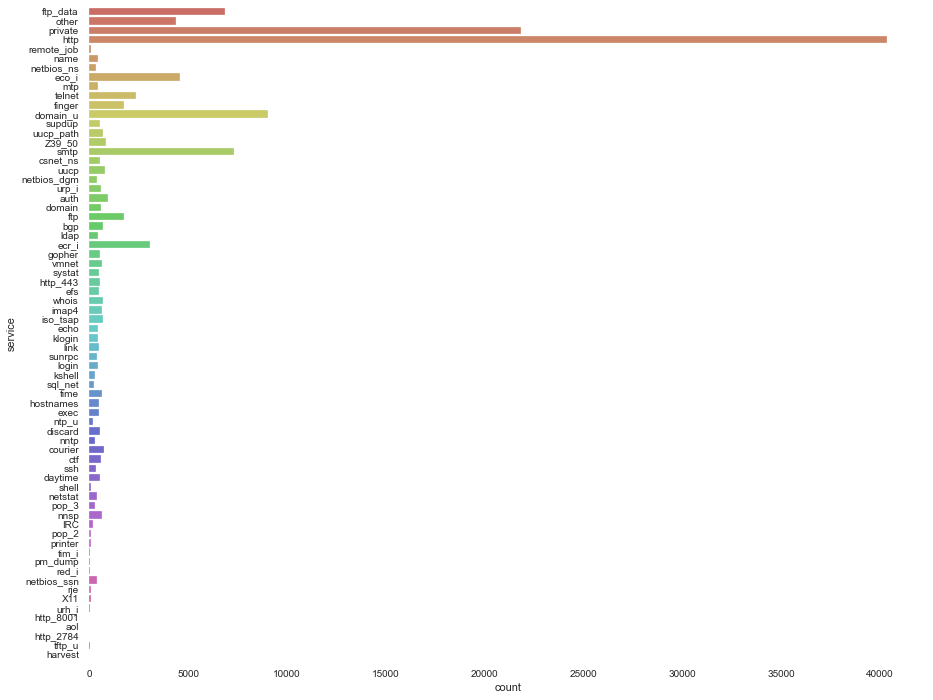

In [30]:
# service distribution
plt.figure(figsize=(15, 12))
sns.countplot(y="service", data=df_train, palette="hls")
plt.show()

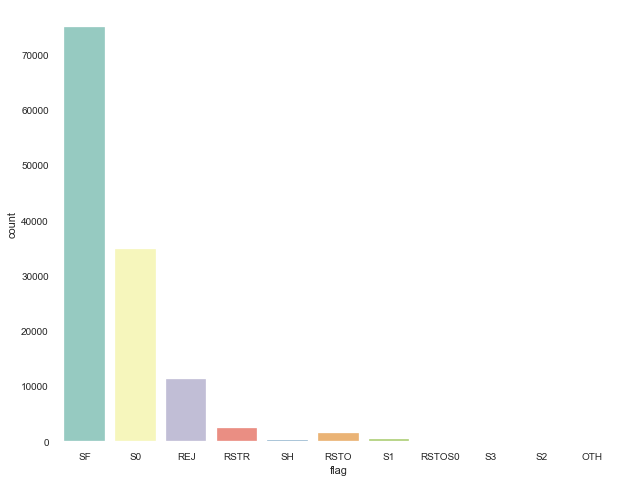

In [31]:
# flag distribution
plt.figure(figsize=(10, 8))
sns.countplot(x="flag", data=df_train, palette="Set3")
plt.show()

In [32]:
#Label column to diagnose the attack values
df_train.attack.value_counts()

0    67343
1    58630
Name: attack, dtype: int64

0    67343
1    58630
Name: attack, dtype: int64


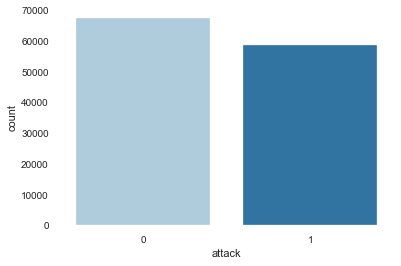

In [33]:
#Checking if the y variable is skewed or not

sns.countplot(x='attack', data=df_train, palette='Paired')

print(df_train.attack.value_counts())

#The y variable is not skewed so we dont need to do sampling of the data.

1    12833
0     9711
Name: attack, dtype: int64


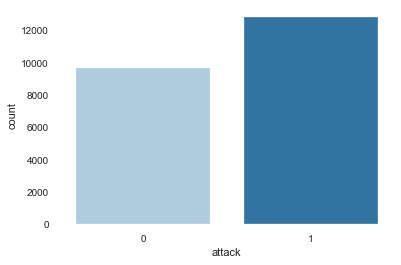

In [34]:
#Checking if the y variable is skewed or not

sns.countplot(x='attack', data=df_test, palette='Paired')

print(df_test.attack.value_counts())

#The y variable is not skewed so we dont need to do sampling of the data.

In [35]:
#Creating Dummy Variables for the nominal categorical variables

cat_dummies = ['protocol_type', 'service', 'flag']
#for c_feature in categorical_features

# for c_feature in categorical_features
for c_feature in [cat_dummies]:
    df_train_cat[c_feature] = df_train_cat[c_feature].astype('category')
    df_train_cat = create_dummies(df_train_cat, c_feature)

In [36]:
df_train_cat.head()

,protocol_type_tcp,protocol_type_udp,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [37]:
# for c_feature in categorical_features
for c_feature in [cat_dummies]:
    df_test_cat[c_feature] = df_test_cat[c_feature].astype('category')
    df_test_cat = create_dummies(df_test_cat, c_feature)

In [38]:
df_test_cat.head()

,protocol_type_tcp,protocol_type_udp,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Final Data for Analysis

In [39]:
df_train_new = pd.concat([df_train_cont, df_train_cat], axis=1)
df_test_new = pd.concat([df_test_cont, df_test_cat], axis=1)

In [40]:
df_train_new.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [41]:
df_test_new.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,0,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0.0,0,0.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2.0,12983,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0.0,20,0.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1.0,0,15.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [42]:
#Correlation check.

df_train_new.corr()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
duration,1.000000,0.011740,0.036892,NaN,NaN,NaN,0.021274,NaN,-0.064537,0.062081,...,-0.043311,-0.003733,0.020369,0.497641,-0.085618,-0.007463,-0.004180,0.004280,-0.034731,-0.006428
src_bytes,0.011740,1.000000,0.127827,NaN,NaN,NaN,0.379973,NaN,0.163275,0.603363,...,-0.052480,-0.016138,0.007541,0.018268,-0.103727,0.041955,0.011526,0.031067,0.117345,-0.007788
dst_bytes,0.036892,0.127827,1.000000,NaN,NaN,NaN,0.127002,NaN,0.422000,0.237363,...,-0.110385,-0.033535,-0.010092,-0.021514,-0.218180,0.137051,0.043579,0.008654,0.260372,-0.016381
land,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wrong_fragment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
flag_S1,-0.007463,0.041955,0.137051,NaN,NaN,NaN,0.005006,NaN,0.052719,0.019502,...,-0.016867,-0.006040,-0.001542,-0.007546,-0.033338,1.000000,-0.001712,-0.001063,-0.065329,-0.002503
flag_S2,-0.004180,0.011526,0.043579,NaN,NaN,NaN,0.068759,NaN,0.033628,-0.000738,...,-0.009940,-0.003560,-0.000909,-0.004447,-0.019646,-0.001712,1.000000,-0.000627,-0.038499,-0.001475
flag_S3,0.004280,0.031067,0.008654,NaN,NaN,NaN,0.005233,NaN,0.019436,0.002002,...,-0.006172,-0.002210,-0.000564,-0.002761,-0.012199,-0.001063,-0.000627,1.000000,-0.023906,-0.000916
flag_SF,-0.034731,0.117345,0.260372,NaN,NaN,NaN,0.098075,NaN,0.641738,0.073022,...,-0.379191,-0.135793,-0.034668,-0.169644,-0.749485,-0.065329,-0.038499,-0.023906,1.000000,-0.056270


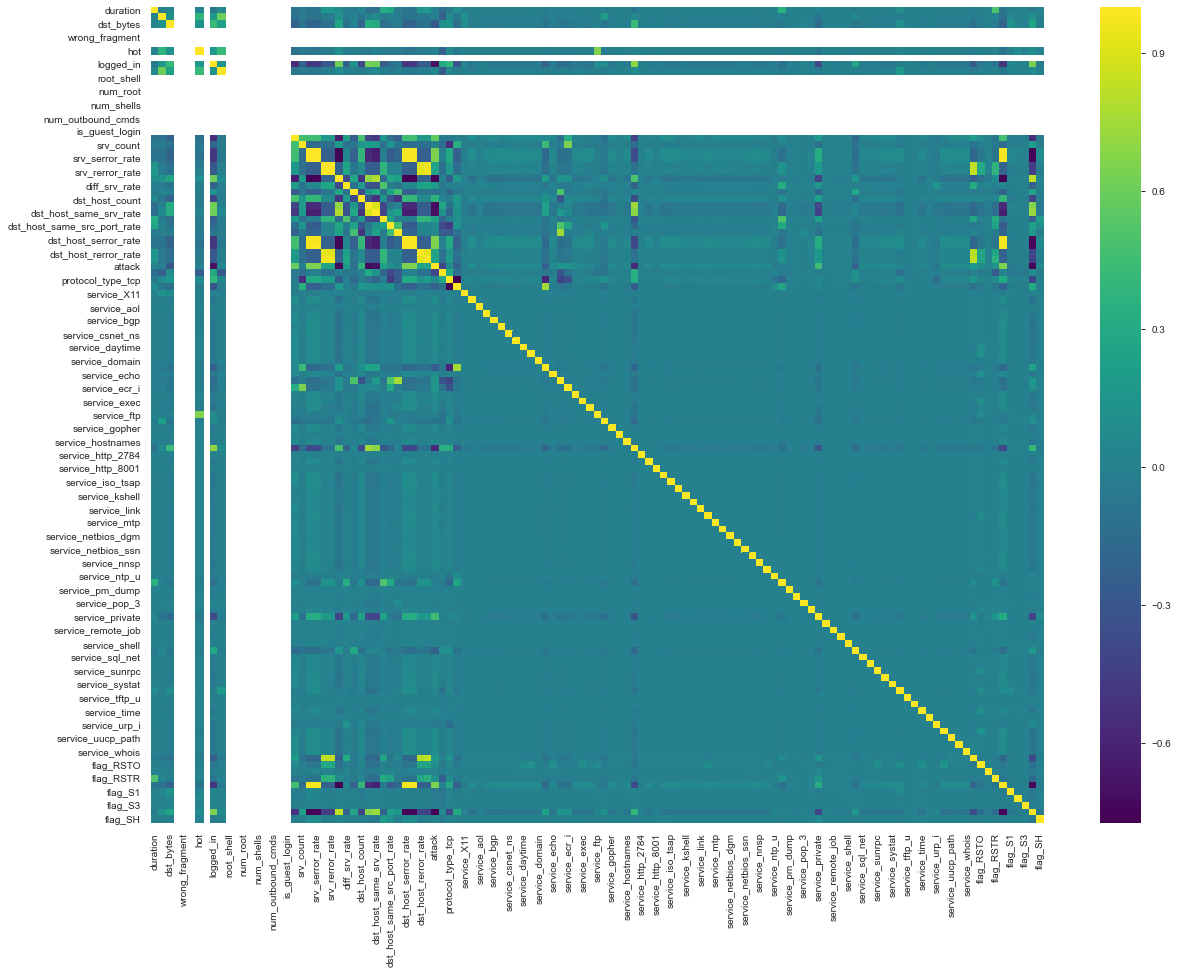

In [45]:
plt.subplots(figsize=(20, 15))
sns.heatmap(df_train_new.corr(), cmap="viridis")
plt.show()

# Dropping columns based on data summarisation and exploratory analysis.

    - Based on low variance (near zero variance, can be seen in the correlation matrix and heat map.)
    - High missings.
    - High correlations between two numerical variables and removing variables which are not important for business context.

In [46]:
df_train_new.drop(columns=[
    'land', 'wrong_fragment', 'urgent', 'num_failed_logins', "root_shell",
    "su_attempted", "num_root", "num_file_creations", "num_shells",
    "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    'dst_host_rerror_rate', 'dst_host_serror_rate', 'dst_host_srv_rerror_rate',
    'dst_host_srv_serror_rate', 'num_root', 'num_outbound_cmds',
    'srv_rerror_rate', 'srv_serror_rate'
],
                  axis=1,
                  inplace=True)

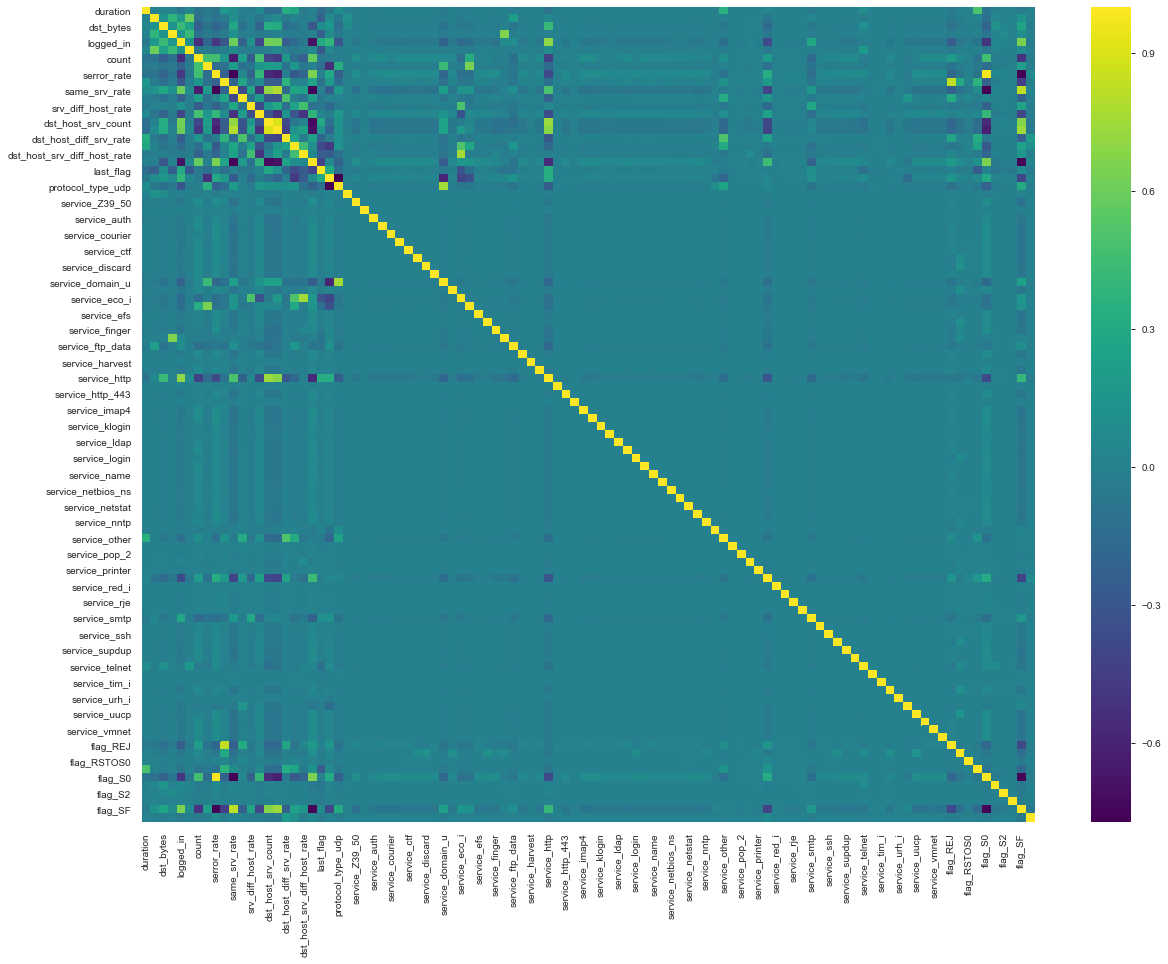

In [47]:
plt.subplots(figsize=(20, 15))
sns.heatmap(df_train_new.corr(), cmap="viridis")
plt.show()

## Feature selection using RFE

In [243]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

#X = df_train_new[df_train_new.columns.difference(['attack'])]
feature_columns = df_train_new.columns.difference(['attack'])

logreg = LogisticRegression(solver='lbfgs')
rfe = RFE(logreg, n_features_to_select=20, verbose=10)

rfe = rfe.fit(df_train_new[feature_columns], df_train_new['attack'])

print(rfe.support_)
print(rfe.ranking_)

Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 

In [244]:
X_final = df_train_new[feature_columns[rfe.support_]]
y_final = df_train_new['attack']

## Multi Collinearity Check - VIF

In [245]:
#Selecting significant variables
feature = df_train_new[feature_columns[rfe.support_]].columns

model_param = 'attack ~ ' + ' + '.join(feature)

In [246]:
# High VIF of the variable means information in that variable has already been explained by
# other X variables present in the model

# import the packages for vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# separate the Y and X variables
y, X = dmatrices(model_param, df_train_new, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [
    variance_inflation_factor(X.values, i) for i in range(X.shape[1])
]

# display the output
features = list(
    vif.round(1).sort_values(by='VIF Factor', ascending=False).loc[:,
                                                                   'Features'])
features

vif


#Ideally VIF values more than 5 have a high multicollinearity. Ideally we should remove these variables for our analysis.

,Features,VIF Factor
0,Intercept,12.081321
1,dst_host_same_src_port_rate,1.829128
2,dst_host_same_srv_rate,4.239239
3,dst_host_srv_diff_host_rate,2.530035
4,flag_S0,34.022594
5,flag_S1,1.292660
6,flag_S2,1.130016
7,hot,2.759097
8,num_compromised,1.578385
9,rerror_rate,1.636547


In [247]:
#Removing the highly multicolinear variables

features_final = feature.difference(['flag_S0 ','serror_rate'])
model_param_final = 'attack ~ ' + ' + '.join(features_final)

In [248]:
#VIF after removing the highly multicollinear variables

# High VIF of the variable means information in that variable has already been explained by
# other X variables present in the model
# separate the Y and X variables
y, X = dmatrices(model_param_final, df_train_new, return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF Factor'] = [
    variance_inflation_factor(X.values, i) for i in range(X.shape[1])
]

# display the output
features_final = list(
    vif.round(1).sort_values(by='VIF Factor', ascending=False).loc[:,
                                                                   'Features'])

vif

#We have ideal VIF's now in our dataset.

,Features,VIF Factor
0,Intercept,11.719657
1,dst_host_same_src_port_rate,1.827073
2,dst_host_same_srv_rate,4.150580
3,dst_host_srv_diff_host_rate,2.529802
4,flag_S0,2.643873
5,flag_S1,1.008930
6,flag_S2,1.014369
7,hot,2.758804
8,num_compromised,1.578385
9,rerror_rate,1.607088


In [249]:
#features_final = features_final.remove('Intercept')
features_final.remove('Intercept')
features_final
#I have already removed intercept, but ran twice by mistake. Therefore, this error. Kindly ignore this error.

['dst_host_same_srv_rate',
 'service_http',
 'hot',
 'service_eco_i',
 'flag_S0',
 'dst_host_srv_diff_host_rate',
 'service_ftp',
 'dst_host_same_src_port_rate',
 'num_compromised',
 'rerror_rate',
 'service_smtp',
 'service_private',
 'service_ecr_i',
 'service_telnet',
 'service_X11',
 'service_gopher',
 'flag_S2',
 'flag_S1',
 'service_uucp']

In [250]:
#Final data for analysis

X = df_train_new[features_final]
y = df_train_new['attack']

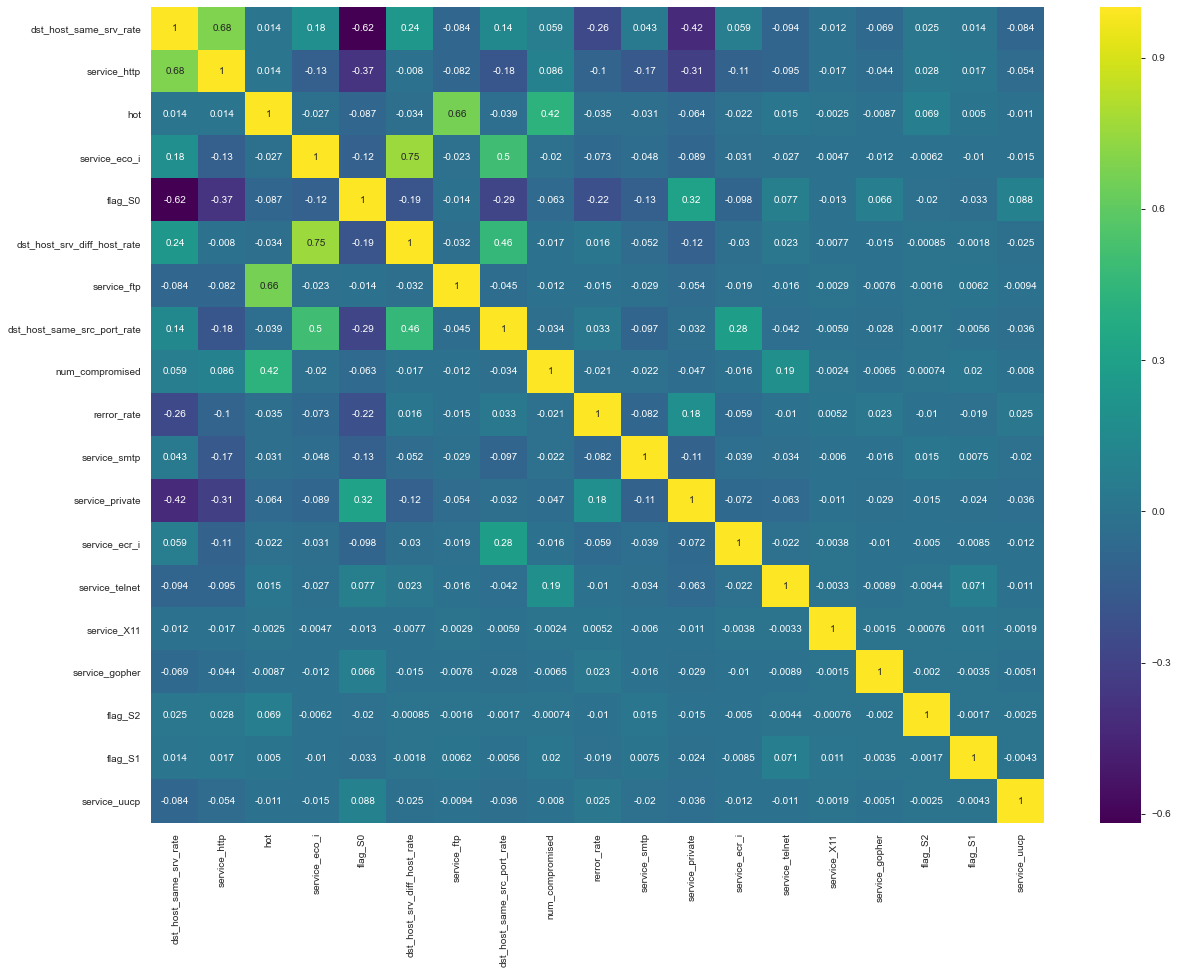

In [251]:
#Corelation check of the new variables

plt.subplots(figsize=(20, 15))
sns.heatmap(X.corr(), cmap="viridis", annot=True)
plt.show()

## Modelling and Predictions

In [252]:
from sklearn.model_selection import train_test_split

df_train_new[features_final]

train_X, test_X, train_y, test_y = train_test_split(X, y,test_size = 0.3, random_state = 12345)

## Building model from statsmodels

In [253]:
# method 2: divide the data into training and testing for statsmodels.formula.api
train, test = train_test_split(df_train_new, test_size = 0.3, random_state = 12345)

In [254]:
# verify the no of obs in training and testing after split
print('No of obs in training: ', len(train), ' | ', 'No of obs in testing: ', len(test))

No of obs in training:  88181  |  No of obs in testing:  37792


In [255]:
import statsmodels.formula.api as smf

model_param_final = 'attack ~ ' + ' + '.join(features_final)
model_param_final

'attack ~ dst_host_same_srv_rate + service_http + hot + service_eco_i + flag_S0 + dst_host_srv_diff_host_rate + service_ftp + dst_host_same_src_port_rate + num_compromised + rerror_rate + service_smtp + service_private + service_ecr_i + service_telnet + service_X11 + service_gopher + flag_S2 + flag_S1 + service_uucp'

In [256]:
lr = smf.logit(formula = model_param_final, data = train).fit()

         Current function value: 0.086735
         Iterations: 35


In [257]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 attack   No. Observations:                88181
Model:                          Logit   Df Residuals:                    88161
Method:                           MLE   Df Model:                           19
Date:                Mon, 13 Apr 2020   Pseudo R-squ.:                  0.8744
Time:                        14:36:36   Log-Likelihood:                -7648.4
converged:                      False   LL-Null:                       -60913.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -3.6596      0.064    -57.287      0.000      -3.785      -3.534
dst_host_same_srv_rate         -2.7279      0.074    -36.800      0.000      -2.873      -2.583
service_http                   -4.5035      0.111    -40.548      0.000      -4.721      -4.286
hot                             2.5616      0.059     43.224      0.000       2.445       2.678
service_eco_i                   3.7262      0.093     40.283      0.000       3.545       3.908
flag_S0                        10.6344      0.134     79.360      0.000      10.372      10.897
dst_host_srv_diff_host_rate     5.8436      0.224     26.141      0.000       5.406       6.282
service_ftp                    -4.0459      0.161    -25.122      0.000      -4.362      -3.730
dst_host_same_src_port_rate     2.8899      0.076     38.170      0.000       2.742       3.038
num_compromised                 6.9544      0.145     47.988      0.000       6.670       7.238
rerror_rate                     7.1236      0.100     71.369      0.000       6.928       7.319
service_smtp                   -3.7639      0.197    -19.095      0.000      -4.150      -3.378
service_private                 5.0833      0.087     58.427      0.000       4.913       5.254
service_ecr_i                   6.2698      0.108     58.203      0.000       6.059       6.481
service_telnet                 -3.6452      0.127    -28.688      0.000      -3.894      -3.396
service_X11                    -3.9825      1.178     -3.379      0.001      -6.292      -1.673
service_gopher                 18.7425    871.114      0.022      0.983   -1688.610    1726.095
flag_S2                         1.7117      0.491      3.485      0.000       0.749       2.674
flag_S1                        -1.1213      0.608     -1.843      0.065      -2.313       0.071
service_uucp                   30.5597   1.28e+06   2.38e-05      1.000   -2.52e+06    2.52e+06
===============================================================================================

Possibly complete quasi-separation: A fraction 0.42 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [259]:
lr.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Logit
===========================================================================================
Model:                        Logit                    Pseudo R-squared:         0.874     
Dependent Variable:           attack                   AIC:                      15336.7625
Date:                         2020-04-13 14:38         BIC:                      15524.5054
No. Observations:             88181                    Log-Likelihood:           -7648.4   
Df Model:                     19                       LL-Null:                  -60913.   
Df Residuals:                 88161                    LLR p-value:              0.0000    
Converged:                    0.0000                   Scale:                    1.0000    
No. Iterations:               35.0000                                                      
-------------------------------------------------------------------------------------------
                             Coef.    Std.Err.      z     P>|z|      [0.025       0.975]   
-------------------------------------------------------------------------------------------
Intercept                   -3.6596       0.0639 -57.2872 0.0000       -3.7848      -3.5344
dst_host_same_srv_rate      -2.7279       0.0741 -36.7997 0.0000       -2.8732      -2.5826
service_http                -4.5035       0.1111 -40.5477 0.0000       -4.7212      -4.2859
hot                          2.5616       0.0593  43.2240 0.0000        2.4454       2.6777
service_eco_i                3.7262       0.0925  40.2826 0.0000        3.5449       3.9075
flag_S0                     10.6344       0.1340  79.3603 0.0000       10.3718      10.8970
dst_host_srv_diff_host_rate  5.8436       0.2235  26.1411 0.0000        5.4055       6.2818
service_ftp                 -4.0459       0.1610 -25.1225 0.0000       -4.3616      -3.7303
dst_host_same_src_port_rate  2.8899       0.0757  38.1699 0.0000        2.7415       3.0383
num_compromised              6.9544       0.1449  47.9882 0.0000        6.6704       7.2384
rerror_rate                  7.1236       0.0998  71.3689 0.0000        6.9280       7.3192
service_smtp                -3.7639       0.1971 -19.0949 0.0000       -4.1502      -3.3775
service_private              5.0833       0.0870  58.4272 0.0000        4.9128       5.2538
service_ecr_i                6.2698       0.1077  58.2031 0.0000        6.0587       6.4809
service_telnet              -3.6452       0.1271 -28.6877 0.0000       -3.8943      -3.3962
service_X11                 -3.9825       1.1785  -3.3793 0.0007       -6.2923      -1.6727
service_gopher              18.7425     871.1142   0.0215 0.9828    -1688.6099    1726.0950
flag_S2                      1.7117       0.4911   3.4854 0.0005        0.7492       2.6743
flag_S1                     -1.1213       0.6083  -1.8434 0.0653       -2.3135       0.0709
service_uucp                30.5597 1284630.1761   0.0000 1.0000 -2517798.3190 2517859.4383
===========================================================================================

"""

I have ran the Logistic Regression multiple times by choosing the no.of variables many times (did not include in the code so the notebook does not become messy).
I chose the best model based on trial and error.

## Building model from sklearn

In [302]:
from sklearn.linear_model import LogisticRegression

logreg1 = LogisticRegression().fit(train_X,train_y)
logreg1.score(train_X,train_y)
#97.24% accuracy using Logistic Regression

0.9726244882684478

In [303]:
logreg1.intercept_

array([-3.49926077])

In [304]:
logreg1.predict(test_X)

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

In [305]:
y_pred = pd.DataFrame( { 'actual':  test_y,
                                'predicted': logreg1.predict( test_X) } )

In [306]:
print(metrics.accuracy_score( y_pred.actual, y_pred.predicted ))
print(metrics.roc_auc_score( y_pred.actual, y_pred.predicted ))

#Very good accuracy and ROC-AUC score of Test Data

0.9723751058425063
0.9720569126440992


Text(0.5, 12.5, 'Predicted label')

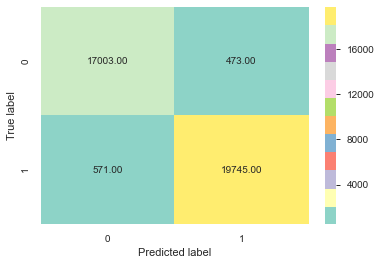

In [307]:
lr_cm = metrics.confusion_matrix(y_pred.predicted, y_pred.actual, [1, 0])
sns.heatmap(lr_cm,
            annot=True,
            cmap='Set3',
            fmt='.2f',
            )

plt.ylabel('True label')
plt.xlabel('Predicted label')

## Building the model from Random Forest Classifier for a better accuracy

In [308]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf1 = RandomForestClassifier(random_state=12345)
rf1.fit(train_X,train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [309]:
rf1.score(train_X,train_y)
#We  get a 99.25% accuracy with the Random Forest Classifier model.

0.9926514782095917

In [310]:
rf1.predict(test_X)

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

In [311]:
y_pred1 = pd.DataFrame( { 'actual':  test_y,
                                'predicted': rf1.predict( test_X) } )

In [312]:
y_pred1

,actual,predicted
112168,1,1
66607,0,0
108068,1,1
81121,1,1
31292,1,1
...,...,...
80385,1,1
120029,1,1
3457,1,1
62256,0,0


In [313]:
print(metrics.accuracy_score(y_pred.actual, y_pred1.predicted))
print(metrics.roc_auc_score(y_pred.actual, y_pred1.predicted))

#Better accuracy of Test Data from Logistic Regression

0.9903154106689246
0.9901710369153309


Text(0.5, 12.5, 'Predicted label')

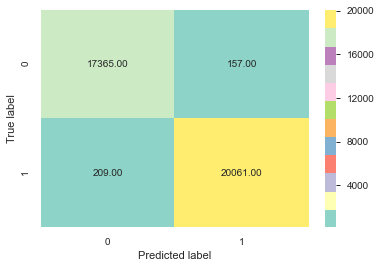

In [314]:
rftree_cm = metrics.confusion_matrix(y_pred1.predicted, y_pred.actual, [1, 0])
sns.heatmap(rftree_cm,
            annot=True,
            cmap='Set3',
            fmt='.2f',
            )

plt.ylabel('True label')
plt.xlabel('Predicted label')

## Implementing Grid Search CV to get a better score and reduce overfitting and reduce multicollinearity (if any).

In [315]:
param_grid = {
    'n_estimators': [70, 80, 90, 100, 120, 150, 200],
    'max_features': [5, 6, 7, 8, 9, 10],
}

rgscv = GridSearchCV(RandomForestClassifier(random_state=12345),
                     param_grid,
                     cv=10,
                     verbose=10,
                     n_jobs=-1)

rgscv.fit(train_X, train_y)

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [316]:
rgscv.best_params_

{'max_features': 5, 'n_estimators': 90}

In [317]:
rgscv.best_score_

#99.04% score

0.9901565996590126

In [318]:
rgscv.predict(test_X)

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

In [319]:
y_pred2 = pd.DataFrame( { 'actual':  test_y,
                                'predicted': rgscv.predict( test_X) } )

In [320]:
y_pred2

,actual,predicted
112168,1,1
66607,0,0
108068,1,1
81121,1,1
31292,1,1
...,...,...
80385,1,1
120029,1,1
3457,1,1
62256,0,0


In [321]:
print(metrics.accuracy_score(y_pred.actual, y_pred2.predicted))
print(metrics.roc_auc_score(y_pred.actual, y_pred2.predicted))

#Better score than a single Random Forest Classifier

0.9904477138018628
0.9903132925202017


Text(0.5, 12.5, 'Predicted label')

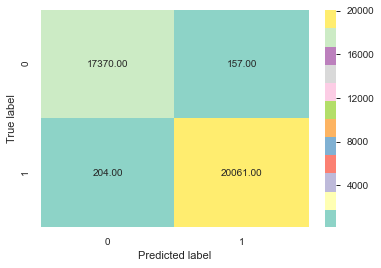

In [322]:
rfgsv_cm = metrics.confusion_matrix(y_pred2.predicted, y_pred.actual, [1, 0])
sns.heatmap(rfgsv_cm,
            annot=True,
            cmap='Set3',
            fmt='.2f',
            )

plt.ylabel('True label')
plt.xlabel('Predicted label')

## Running Boosting Methods to test the accuracy and ROC score of the models.

In [323]:
from sklearn.ensemble import GradientBoostingClassifier

pargrid_grad = {'n_estimators': [50, 70, 90, 100, 200],
                   'learning_rate': [10 ** x for x in range(-3, 1)]}

gscv_grad = GridSearchCV(estimator = GradientBoostingClassifier(), 
                        param_grid = pargrid_grad, 
                        cv = 5,
                        verbose = True, 
                        n_jobs = -1)

gscv_grad.fit(train_X,train_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [324]:
gscv_grad.best_params_

{'learning_rate': 1, 'n_estimators': 200}

In [325]:
gscv_grad.best_score_

0.9882854418520786

In [326]:
gscv_grad.predict(test_X)

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

In [327]:
y_pred3 = pd.DataFrame( { 'actual':  test_y,
                                'predicted': gscv_grad.predict( test_X) } )

In [328]:
y_pred3

,actual,predicted
112168,1,1
66607,0,0
108068,1,0
81121,1,1
31292,1,1
...,...,...
80385,1,1
120029,1,1
3457,1,1
62256,0,0


In [329]:
print(metrics.accuracy_score(y_pred.actual, y_pred3.predicted))
print(metrics.roc_auc_score(y_pred.actual, y_pred3.predicted))


0.9881985605419137
0.9879358747476564


Text(0.5, 12.5, 'Predicted label')

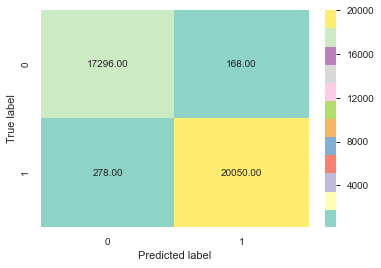

In [334]:
grad_cm = metrics.confusion_matrix(y_pred3.predicted, y_pred.actual, [1, 0])
sns.heatmap(
    grad_cm,
    annot=True,
    cmap='Set3',
    fmt='.2f',
)

plt.ylabel('True label')
plt.xlabel('Predicted label')

We have the best score with Random Forest Classifier which ran with Grid Search CV.
We will use those predicted values for our analysis.

## Predictions

In [351]:
# Step 4: predict the spend on the testing/validation data
test_X['Predictions'] = rgscv.predict(test_X)

#I have already run this code and Predictions column came up. This error came because Predictions is already there and there is one column more.

ValueError: Number of features of the model must match the input. Model n_features is 19 and input n_features is 20 

In [356]:
test = pd.concat([test_X, test_y], axis =1)

In [359]:
test[['attack','Predictions']]

,attack,Predictions
112168,1,1
66607,0,0
108068,1,1
81121,1,1
31292,1,1
...,...,...
80385,1,1
120029,1,1
3457,1,1
62256,0,0


In [367]:
##Predicting the y variable on the new test dataset

testX = df_test_new[features_final]
testy = df_test_new['attack']

In [377]:
rgscv.fit(testX,testy)  #Random Forest Classifier which we ran before to test our accuracies where we got 99.4% accuracy.

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [378]:
rgscv.best_score_

0.955864085921653

In [379]:
rgscv.best_params_

{'max_features': 9, 'n_estimators': 90}

In [380]:
testX['Predictions'] = rgscv.predict(testX)

In [381]:
testnew = pd.concat([testX, testy], axis =1)

In [382]:
testnew[['attack','Predictions']]

,attack,Predictions
0,1,1
1,1,1
2,0,0
3,1,1
4,1,1
...,...,...
22539,0,0
22540,0,0
22541,1,1
22542,0,0


In [391]:
print('The accuracy score with the Random Forest Classifier with test data',
      metrics.accuracy_score(y_pred.actual, y_pred2.predicted))
print('The accuracy score with the Random Forest Classifier with test data',
      metrics.roc_auc_score(y_pred.actual, y_pred2.predicted))

print(
    'The accuracy score with the Random Forest Classifier with the new test data',
    metrics.accuracy_score(testnew.attack, testnew.Predictions))
print(
    'The accuracy score with the Random Forest Classifier with the new test data',
    metrics.roc_auc_score(testnew.attack, testnew.Predictions))

The accuracy score with the Random Forest Classifier with test data 0.9904477138018628
The accuracy score with the Random Forest Classifier with test data 0.9903132925202017
The accuracy score with the Random Forest Classifier with the new test data 0.9687278211497516
The accuracy score with the Random Forest Classifier with the new test data 0.9660182588584422


## Important Notes

We got out best score using Random Forest Classifier.
The predictions score with the test data in the train dataset comes to be around 99%.

If we get a new dataset(test dataset) we got a prediction score of around 97%.

So, our prediction to find if a network is attacked or not is around 97%

We will do the multinomial classification on another jupyter notebook attached with the assignment zip.